# 3.Basic spatial domain-cell analysis

This notebook implements the basic domain-cell analysis in spateo paper:

1. Cell-Domain specificity and heterogeneity analysis 
 (i.e. cell composition in each domain & cell distribution among domains)
2. Celltype co-localization analysis 
 (based on spatial nearest neighbors)

## Packages

In [1]:
import numpy as np
import pandas as pd

import spateo as st
import dynamo as dyn

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import isspmatrix

to_dense_matrix = lambda X: np.array(X.todense()) if isspmatrix(X) else np.asarray(X)

st.configuration.set_pub_style_mpltex()
%matplotlib inline

2022-11-11 00:56:20.352725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


## Data source
**bin60_clustered_h5ad:** https://www.dropbox.com/s/wxgkim87uhpaz1c/mousebrain_bin60_clustered.h5ad?dl=0

**cellbin_clustered_h5ad:** https://www.dropbox.com/s/seusnva0dgg5de5/mousebrain_cellbin_clustered.h5ad?dl=0


In [2]:
# Load annotated binning data
fname_bin60 = "mousebrain_bin60_clustered.h5ad"
adata_bin60 = st.sample_data.mousebrain(fname_bin60)

# Load annotated cellbin data
fname_cellbin = "mousebrain_cellbin_clustered.h5ad"
adata_cellbin = st.sample_data.mousebrain(fname_cellbin)

adata_bin60, adata_cellbin

(AnnData object with n_obs × n_vars = 7765 × 21667
     obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc', 'scc_anno'
     var: 'pass_basic_filter'
     uns: '__type', 'louvain', 'louvain_colors', 'neighbors', 'pp', 'scc', 'scc_anno_colors', 'scc_colors', 'spatial', 'spatial_neighbors'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances',
 AnnData object with n_obs × n_vars = 11854 × 14645
     obs: 'area', 'pass_basic_filter', 'n_counts', 'louvain', 'Celltype'
     var: 'mt', 'pass_basic_filter'
     uns: 'Celltype_colors', '__type', 'louvain', 'neighbors', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances')

## Cell-Domain specificity and heterogeneity

In [ ]:
# Extract spatial domains from SCC clusters.
# Transfer domain annotation to cells.
st.dd.set_domains(
    adata_high_res=adata_cellbin,
    adata_low_res=adata_bin60,
    bin_size_high=1,
    bin_size_low=60,
    cluster_key="scc_anno",
    domain_key_prefix="transfered_domain",
    k_size=1.8,
    min_area=16,
)

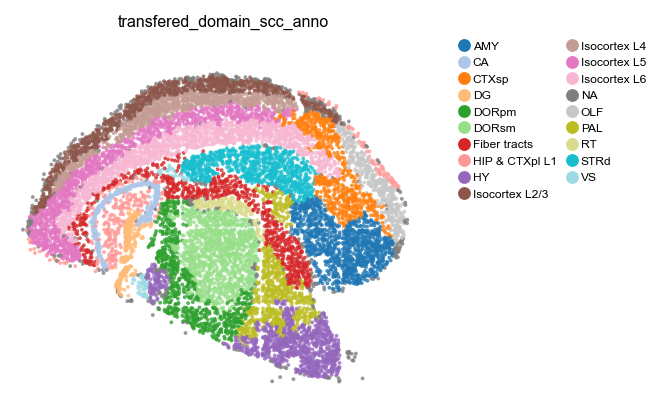

In [4]:
# View cell domain
st.pl.space(
    adata_cellbin,
    color=['transfered_domain_scc_anno'],
    pointsize=0.1,
    show_legend="upper left",
    figsize=(4, 3),
    color_key_cmap = "tab20",
)

In [5]:
# Summary domain-cell relationship
domain_list = np.array([])
celltype_list = np.array([])
count_list = np.array([])
for i in np.unique(adata_cellbin.obs['transfered_domain_scc_anno']):
    tmp, counts = np.unique(adata_cellbin[adata_cellbin.obs['transfered_domain_scc_anno'] == i,:].obs['Celltype'], return_counts=True)
    domain_list = np.append(domain_list, np.repeat(i, len(counts)))
    celltype_list = np.append(celltype_list, tmp)
    count_list = np.append(count_list, counts)
hetero_df = pd.DataFrame({"domain":domain_list, "celltype":celltype_list, "count":count_list.astype(int)})

hetero_df[0:10]

,domain,celltype,count
0,AMY,AMY neuron,418
1,AMY,AST,98
2,AMY,COP,1
3,AMY,EX,70
4,AMY,EX AMY,4
5,AMY,EX CA,1
6,AMY,EX L5/6,4
7,AMY,EX PIR,8
8,AMY,HY neuron,182
9,AMY,Habenula neuron,1


<AxesSubplot:title={'center':'Stacked Bar Graph'}, ylabel='Celltype'>

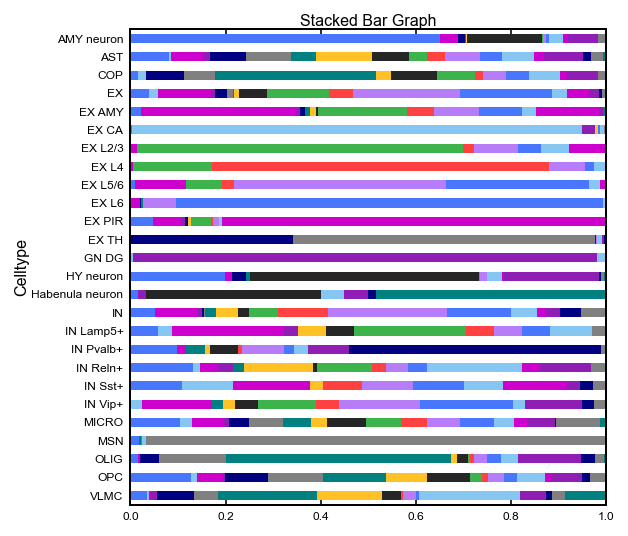

In [6]:
# Cell distribution among domains
spec_df_plt = hetero_df.pivot(index="celltype", columns="domain", values="count").fillna(0)
spec_df_plt = spec_df_plt.div(spec_df_plt.sum(axis=1), axis=0)

spec_df_plt['Celltype'] = spec_df_plt.index
spec_df_plt.index = pd.CategoricalIndex(spec_df_plt.index, categories=spec_df_plt.index.astype(str).sort_values())
spec_df_plt = spec_df_plt.sort_index(ascending=False)

spec_df_plt.plot(
    x = 'Celltype',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    figsize=(4, 4),
    legend = False,
)

<AxesSubplot:xlabel='domain', ylabel='celltype'>

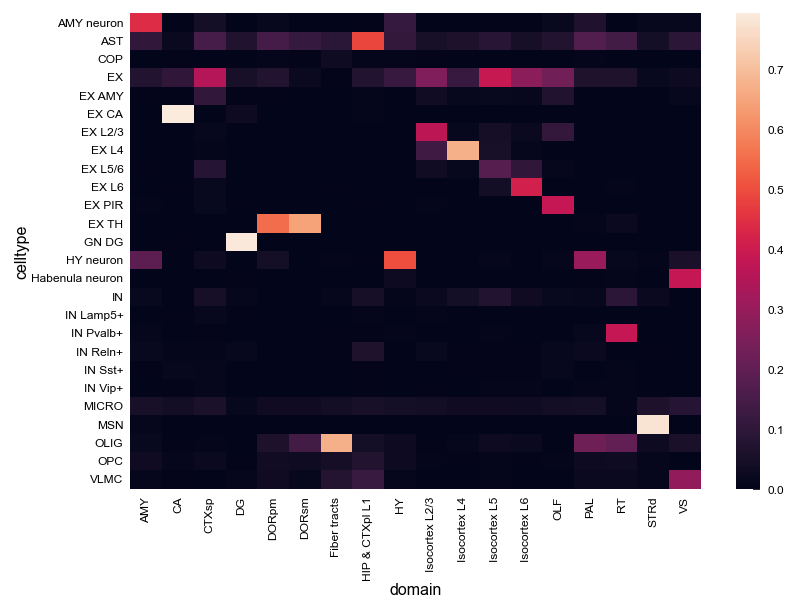

In [7]:
# Cell composition within each domain
hetero_df_plt = hetero_df[hetero_df.domain!="NA"].pivot(index="domain", columns="celltype", values="count").fillna(0)
hetero_df_plt = hetero_df_plt.div(hetero_df_plt.sum(axis=1), axis=0)

sns.heatmap(hetero_df_plt.T)

In [ ]:
# Celltype co-localization (OPC and others)
# Doing dyn.tl.neighbors for N times is easy but time comsuming. (One time is enough, to be optimized soon)
# Should hide the logging of this codeblock (neighbor finding outputs too much log)

celltype_of_interest = "OPC"

n_neigh = []
neigh_type = []
neigh_cnt = []
for i in range(0,100):
    dyn.tl.neighbors(
        adata_cellbin,
        X_data=adata_cellbin.obsm['spatial'],
        n_neighbors=i+2,
        result_prefix="spatial",
        n_pca_components=30, # doesn't matter
    )
    sp_con = adata_cellbin.obsp['spatial_connectivities'][adata_cellbin.obs['Celltype']==celltype_of_interest, :].copy()
    sp_con.data[sp_con.data > 0] = 1
    sp_con = to_dense_matrix(sp_con)
    for k in range(sp_con.shape[0]):
        for j in np.unique(adata_cellbin.obs['Celltype']):
            n_neigh.append(i)
            neigh_type.append(j)
            neigh_cnt.append(sum(sp_con[k,adata_cellbin.obs['Celltype'] == j]) / sum(sp_con[k,:]))

df_plt = pd.DataFrame({"Neighbors":n_neigh, "Celltype":neigh_type, "Percentage":neigh_cnt})

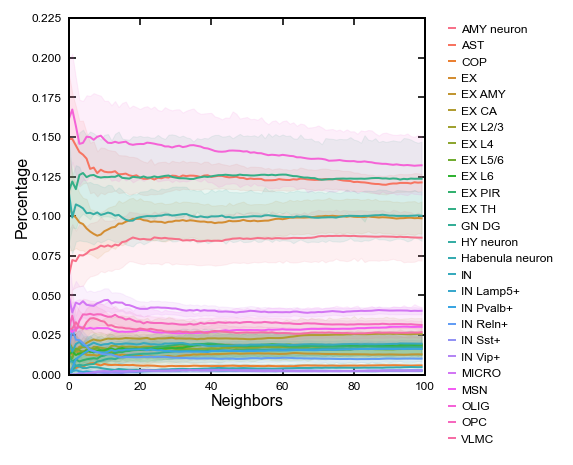

In [9]:
# Celltype co-localization (OPC and others)
# Lineplot in spateo paper

fig = plt.figure(figsize=(3, 3))
sns.lineplot(data=df_plt, x='Neighbors', y='Percentage', hue='Celltype',ci=90, err_kws={"alpha": 0.1})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)